In [23]:

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)


In [24]:
def get_historical_data(symbol, start_date):
    api_key = 'cf7ef863b87b44c1a8a6e08d8596d67d'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

aapl = get_historical_data('AAPL', '2010-01-01')
aapl.tail()

,open,high,low,close,volume
datetime,,,,,
2023-09-12,179.49001,180.13000,174.82001,176.30000,90370200.0
2023-09-13,176.50999,177.30000,173.98000,174.21001,84267900.0
2023-09-14,174.00000,176.10001,173.58000,175.74001,60895800.0
2023-09-15,176.48000,176.50000,173.82001,175.00999,109205100.0
2023-09-18,177.00999,179.17999,176.44000,178.93010,37498644.0


In [25]:
# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

aapl['%k'], aapl['%d'] = get_stoch_osc(aapl['high'], aapl['low'], aapl['close'], 14, 3)
aapl.tail()


,open,high,low,close,volume,%k,%d
datetime,,,,,,,
2023-09-12,179.49001,180.13000,174.82001,176.30000,90370200.0,16.788372,26.804566
2023-09-13,176.50999,177.30000,173.98000,174.21001,84267900.0,4.075545,18.755139
2023-09-14,174.00000,176.10001,173.58000,175.74001,60895800.0,13.382109,11.415342
2023-09-15,176.48000,176.50000,173.82001,175.00999,109205100.0,8.941600,8.799751
2023-09-18,177.00999,179.17999,176.44000,178.93010,37498644.0,32.786537,18.370082


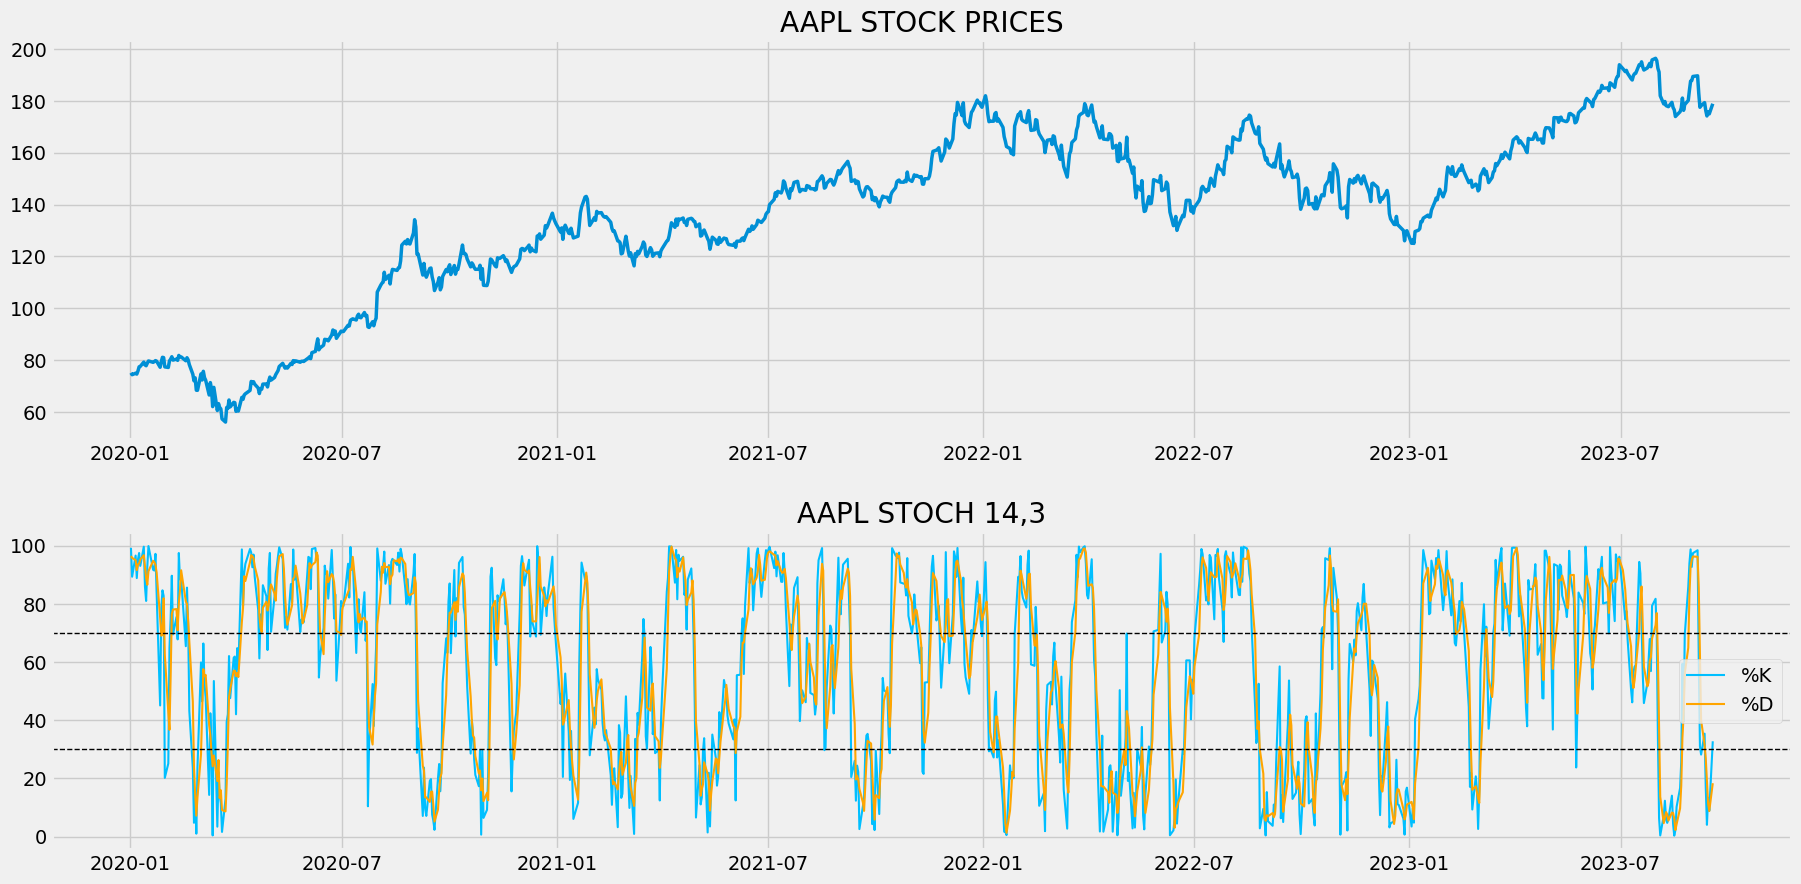

In [26]:
# STOCHASTIC OSCILLATOR PLOT

plot_data = aapl[aapl.index >= '2020-01-01']

ax1 = plt.subplot2grid((14,1), (0,0), rowspan = 7, colspan = 1)
ax2 = plt.subplot2grid((15,1), (9,0), rowspan = 6, colspan = 1)
ax1.plot(plot_data['close'], linewidth = 2.5)
ax1.set_title('AAPL STOCK PRICES')
ax2.plot(plot_data['%k'], color = 'deepskyblue', linewidth = 1.5, label = '%K')
ax2.plot(plot_data['%d'], color = 'orange', linewidth = 1.5, label = '%D')
ax2.axhline(70, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(30, color = 'black', linewidth = 1, linestyle = '--')
ax2.set_title(f'AAPL STOCH 14,3')
ax2.legend(loc = 'right')
plt.show()


In [27]:

# MACD CALCULATION

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    return macd, signal, hist

aapl['macd'] = get_macd(aapl['close'], 26, 12, 9)[0]
aapl['macd_signal'] = get_macd(aapl['close'], 26, 12, 9)[1]
aapl['macd_hist'] = get_macd(aapl['close'], 26, 12, 9)[2]
aapl = aapl.dropna()
aapl.tail()


,open,high,low,close,volume,%k,%d,macd,macd_signal,macd_hist
datetime,,,,,,,,,,
2023-09-12,179.49001,180.13000,174.82001,176.30000,90370200.0,16.788372,26.804566,-1.079275,-0.777089,-0.302185
2023-09-13,176.50999,177.30000,173.98000,174.21001,84267900.0,4.075545,18.755139,-1.536576,-0.928987,-0.607589
2023-09-14,174.00000,176.10001,173.58000,175.74001,60895800.0,13.382109,11.415342,-1.755298,-1.094249,-0.661049
2023-09-15,176.48000,176.50000,173.82001,175.00999,109205100.0,8.941600,8.799751,-1.964893,-1.268378,-0.696515
2023-09-18,177.00999,179.17999,176.44000,178.93010,37498644.0,32.786537,18.370082,-1.793999,-1.373502,-0.420497


/tmp/ipykernel_8564/3198336355.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if str(hist[i])[0] == '-':
/tmp/ipykernel_8564/3198336355.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.bar(prices.index[i], hist[i], color = '#26a69a')
/tmp/ipykernel_8564/3198336355.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.bar(prices.index[i], hist[i], color = '#ef5350')


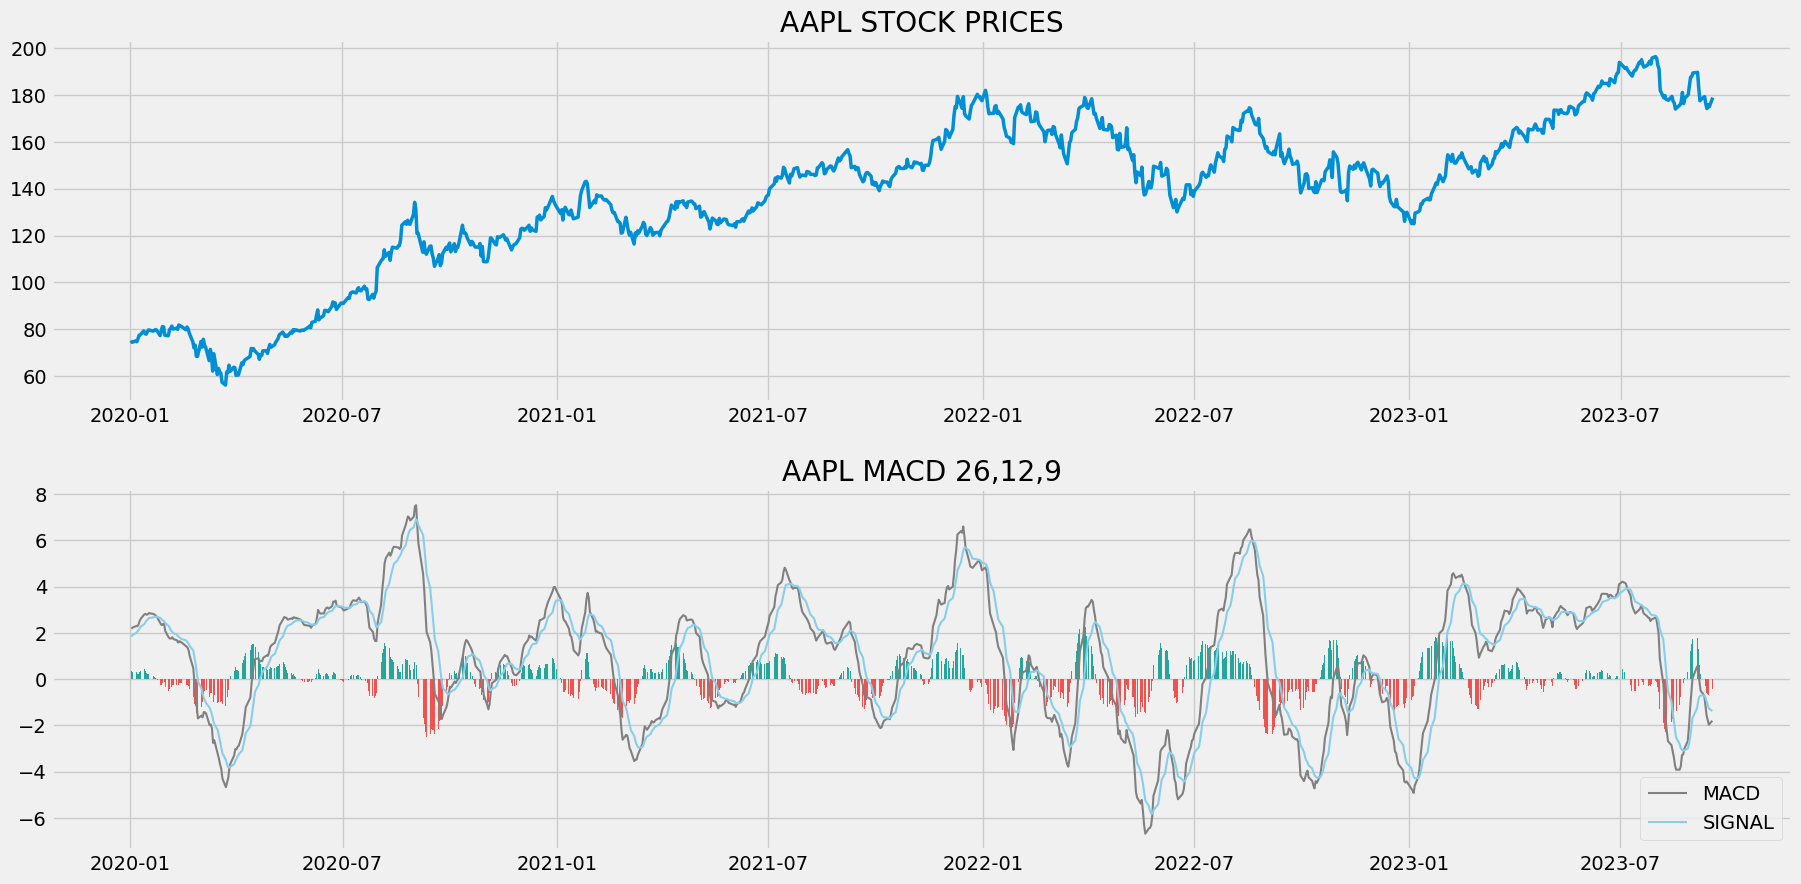

In [28]:
# MACD PLOT

plot_data = aapl[aapl.index >= '2020-01-01']

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)

    ax1.plot(prices, linewidth = 2.5)
    ax1.set_title('AAPL STOCK PRICES')
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax2.set_title('AAPL MACD 26,12,9')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(plot_data['close'], plot_data['macd'], plot_data['macd_signal'], plot_data['macd_hist'])


In [29]:
# TRADING STRATEGY

def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal
            
buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(aapl['close'], aapl['%k'], aapl['%d'], aapl['macd'], aapl['macd_signal'])


/tmp/ipykernel_8564/797069373.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if k[i] < 30 and d[i] < 30 and macd[i] < -2 and macd_signal[i] < -2:
/tmp/ipykernel_8564/797069373.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif k[i] > 70 and d[i] > 70 and macd[i] > 2 and macd_signal[i] > 2:
/tmp/ipykernel_8564/797069373.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_price.append(prices[i])
/tmp/ipykernel_8564/7

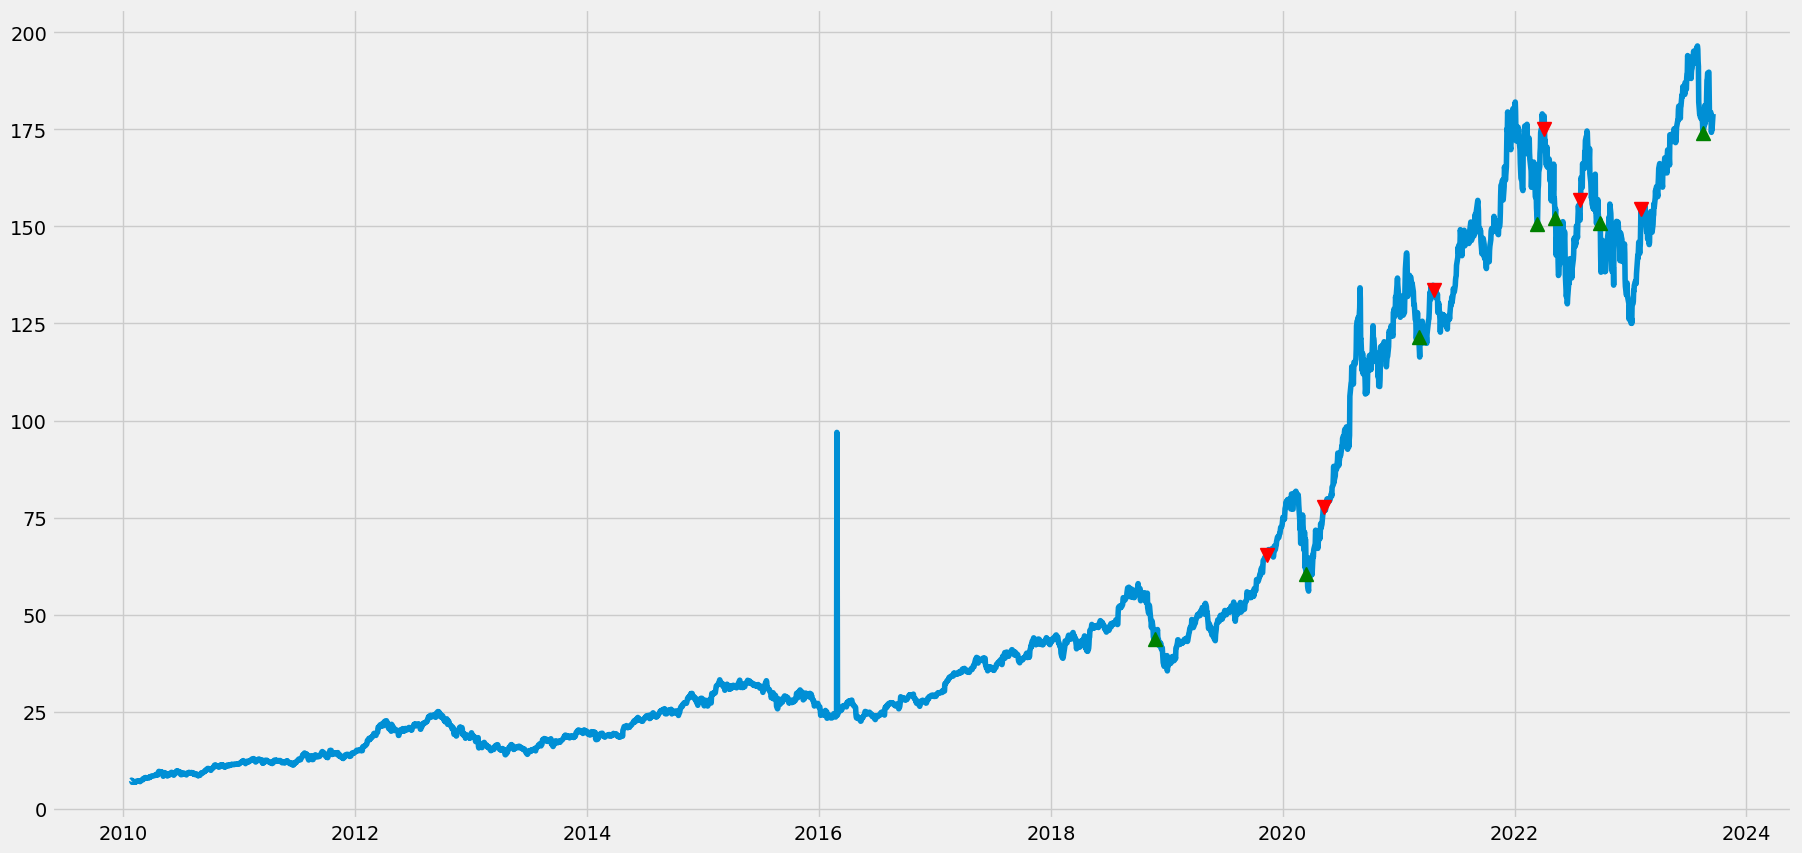

In [30]:

# TRADING SIGNALS PLOT

plt.plot(aapl['close'])
plt.plot(aapl.index, buy_price, marker = '^', markersize = 10, color = 'green')
plt.plot(aapl.index, sell_price, marker = 'v', markersize = 10, color = 'r')

In [31]:
# POSITION

position = []
for i in range(len(stoch_macd_signal)):
    if stoch_macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if stoch_macd_signal[i] == 1:
        position[i] = 1
    elif stoch_macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
k_line = aapl['%k']
d_line = aapl['%d']
macd_line = aapl['macd']
signal_line = aapl['macd_signal']
stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(aapl.index)

frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()
strategy[-75:-70]


,close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
datetime,,,,,,,
2023-06-01,180.09000,99.690718,85.484618,2.812036,2.565914,0,0
2023-06-02,180.95000,92.693598,89.622577,3.071257,2.666983,0,0
2023-06-05,179.58000,63.037389,85.140568,3.130063,2.759599,0,0
2023-06-06,179.21001,60.491160,72.074049,3.110950,2.829869,0,0
2023-06-07,177.82001,50.585614,58.038055,2.949641,2.853823,0,0


In [32]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
stoch_macd_strategy_ret = []

for i in range(len(aapl_ret)):
    try:
        returns = aapl_ret['returns'][i] * strategy['stoch_macd_position'][i]
        stoch_macd_strategy_ret.append(returns)
    except:
        pass
    
stoch_macd_strategy_ret_df = pd.DataFrame(stoch_macd_strategy_ret).rename(columns = {0:'stoch_macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value / aapl['close'][0])
stoch_macd_investment_ret = []

for i in range(len(stoch_macd_strategy_ret_df['stoch_macd_returns'])):
    returns = number_of_stocks * stoch_macd_strategy_ret_df['stoch_macd_returns'][i]
    stoch_macd_investment_ret.append(returns)

stoch_macd_investment_ret_df = pd.DataFrame(stoch_macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(stoch_macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print(cl('Profit gained from the STOCH MACD strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the STOCH MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the STOCH MACD strategy by investing $100k in AAPL : 1705387.97
Profit percentage of the STOCH MACD strategy : 1705%


/tmp/ipykernel_8564/1554153322.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = aapl_ret['returns'][i] * strategy['stoch_macd_position'][i]
/tmp/ipykernel_8564/1554153322.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  number_of_stocks = floor(investment_value / aapl['close'][0])
